# Simple decision rules give high accuracy for detecting social bots on benchmark datasets

Analysis of benchmark datasets for bot detection.

## Setup

In [40]:
from datetime import datetime
from functools import reduce
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import pandas as pd
import pyreadr
import random
from scipy.io import arff
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn import tree, ensemble
from sklearn.tree import export_text
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import time
import xml.etree.ElementTree as ET

In [65]:
PROJ_PATH = "/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection"

def timeit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        print(f"Starting {func.__name__} at {start_time}")
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Finished {func.__name__} at {end_time}. Execution time: {end_time - start_time} s")
        return result
    return wrapper

def extract_users(data_path):
    """
    Load json file with user dictionaries and return.
    """
    with open(data_path) as f:
        d = json.load(f)
        profs = [ent['user'] for ent in d]
    return profs


def preprocess(X, drop_cols, one_hot_cols):
    """
    Drop columns listed by drop_cols, turn one_hot_cols into 
    one-hot variables since decision trees must be fitted on numerical data.
    """
    X.drop(columns=drop_cols, inplace=True)
    one_hot = pd.get_dummies(X, columns=one_hot_cols, drop_first=True)
    return one_hot


def preprocess_users(profs, labels_path):
    """
    Preprocessing user dictionaries.
    - Convert created_at to datetime
    - Read in labels
    - Run preprocess
    - Return dataframe, one_hot dataframe and labels
    """
    df = pd.DataFrame(profs).set_index("id")
    df["created_at"] = df["created_at"].apply(lambda dt: datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y").timestamp())
    labels = pd.read_csv(labels_path, sep="\t", header=None, names=["id", "label_str"], index_col="id")
    labels.loc[labels['label_str']=="human", 'label'] = 0
    labels.loc[labels['label_str']=="bot", 'label'] = 1
    df, labels = df.align(labels, join="inner", axis=0)
    df.reset_index(inplace=True)
    labels = labels['label']
    one_hot = preprocess(df, COLUMNS_TO_DROP + ['profile_banner_url', 'entities', 'id_str', 'following', 'follow_request_sent', 'notifications', 'translator_type'], DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'is_translation_enabled', 'has_extended_profile'])
    return df, one_hot, labels


def fit(X, y, method=None, depth=3):
    """
    Fit a decision tree (or method, if provided) using features X, labels y and maximum depth equal to depth. 
    """
    if method is None:
        # Use decision tree
        clf = tree.DecisionTreeClassifier(max_depth=depth)
    else:
        clf = method
    clf = clf.fit(X, y)
    return clf
 

def score(clf, X, y, method=None, silent=False):
    """
    Score trained model, and print out results if not silent.
    """
    if method is None and not silent:
        r = export_text(clf, feature_names=list(X.columns), show_weights=True)
        print(r)
    accuracy = clf.score(X, y)
    preds = clf.predict(X)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    f1 = f1_score(y, preds)
    if (not silent):
        print(f"Accuracy:", accuracy)
        print(f"Precision", precision)
        print(f"Recall:", recall)
        print(f"F1:", f1)
    return accuracy, precision, recall, f1


def fit_and_score(X, y, method=None, depth=3, silent=False):
    """ 
    Fit model, print out the ascii tree and scores and return the model/scores.
    """
    clf = fit(X, y, method, depth)
    accuracy, precision, recall, f1 = score(clf, X, y, method, silent)
    return clf, accuracy, precision, recall, f1

@timeit
def kfold_cv(X, y, method=None, depth=3, k=5):
    """
    Run fit_and_score k times and compute test score statistics.
    """
    inds = np.random.permutation(len(X))
    scores = []
    fold_size = (len(X) // k)+1
    shuffled_X = X.iloc[inds]
    shuffled_y = y.iloc[inds]
    for i in range(k):
        print(f"Fold {i} in progress")
        # Train test split
        train_X = pd.concat([shuffled_X.iloc[:i*fold_size], shuffled_X.iloc[(i+1)*fold_size:]])
        test_X = shuffled_X.iloc[i*fold_size:(i+1)*fold_size]
        train_y = [label for j,label in enumerate(shuffled_y) if ((j < i*fold_size) or (j >= (i+1)*fold_size))]
        test_y = [label for j,label in enumerate(shuffled_y) if ((j >= i*fold_size) and (j < (i+1)*fold_size))]
        # Fit
        clf = fit(train_X, train_y, depth=depth)
        scr = score(clf, test_X, test_y, method, True)
        scores.append(scr)
    avg_scores = [sum([row[i] for row in scores])/k for i in range(4)]
    return avg_scores
    
@timeit
def train_test_fit_and_score(X, y, method=None, depth=3):
    """ Train test split. """
    train, test, train_labels, test_labels = train_test_split(X, y, test_size=0.3)
    clf, *_ = fit_and_score(train, train_labels, method=method, depth=depth, silent=True)
    score(clf, test, test_labels)


def nonnumeric(df):
    """
    Print out columns that contain NA or have dtype=object.
    """
    print("Columns with NA values:", df.isnull().any()[lambda x: x])
    print("Columns with dtype=object", list(df.select_dtypes(include='object')))
    print("Columns with dtype=bool", list(df.select_dtypes(include='bool')))


@timeit
def mdi_feature_importance(clf, labels, ax):
    """
    Plot most important features.
    
    @param clf: fitted classifier
    """
    importances = clf.feature_importances_
    top10 = np.argsort(importances)[-10:] # Get top 10 most important features
    top10 = top10[::-1]
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    mdi_importances = pd.Series(importances, index=labels)
    mdi_importances[top10].plot.bar(yerr=std[top10], ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    return mdi_importances

@timeit
def permutation_feature_importance(ax, X, y, drop_cols):
    """
    Random forest feature importance on fitted model clf, features. Plot results on ax.
    Warning: computationally expensive, since refits model multiple times.
    """
    processed = preprocess(X, drop_cols, [])
    
    rf = ensemble.RandomForestClassifier(n_estimators=100)
    clf, *_ = fit_and_score(X, y, method=rf, silent=True)

    pi = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=1)
    top10 = np.argsort(pi.importances_mean)[-10:] # Get top 10 most important features
    top10 = top10[::-1]
    pi_importances = pd.Series(pi.importances_mean, index=list(X.columns))
    pi_importances[top10].plot.bar(ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")

def plot_metrics(one_hot, labels, soa_accuracy=None, soa_precision=None, soa_recall=None):
    """ Plot accuracy, precision and recall for different numbers of features. """
    rng = range(1,6)
    models = [fit_and_score(one_hot, labels, depth=i, silent=True) for i in rng]
    clfs, accuracies, precisions, recalls, f1s = zip(*models)
    fig, ax = plt.subplots(figsize=(7,4))
    ax.scatter(rng, accuracies, label="Accuracy")
    ax.scatter(rng, precisions, label="Precision")
    ax.scatter(rng, recalls, label="Recall")
    ax.set_title("Accuracy, precision and recall as a function of model complexity")
    ax.set_xlabel("Model complexity (tree depth)")
    ax.set_ylabel("Score")
    ax.set_ylim([0,1.05])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    if soa_accuracy:
        plt.axhline(y= soa_accuracy, color='C0', linestyle='-', label="State-of-art accuracy")
    if soa_precision:
        plt.axhline(y= soa_precision, color='C1', linestyle='-', label="State-of-art precision")
    if soa_recall:
        plt.axhline(y= soa_recall, color='C2', linestyle='-', label="State-of-art recall")
    ax.legend()
    plt.tight_layout()
    
def calculate_accuracy(precision, recall, num_bots, num_humans):
    """
    Calculate accuracy from precision, recall and support.
    """
    total = num_bots + num_humans
    true_positive = num_bots * recall
    true_negative = total - true_positive * (1/precision + 1/recall - 2)
    false_negative = num_bots - true_positive
    false_positive = num_humans - true_negative
    return (true_positive + true_negative) / total

In [3]:
COLUMNS_TO_DROP = ['id', 
                   'name', 
                   'screen_name', 
                   'url', 
                   'profile_image_url', 
                   'profile_background_image_url_https', 
                   'description',
                   'profile_image_url_https', 
                   'profile_background_image_url', 
                   'profile_text_color', 
                   'profile_sidebar_border_color', 
                   'profile_sidebar_fill_color', 
                   'profile_background_color', 
                   'profile_link_color']
DUMMY_COLUMNS = ['lang', 
                  'time_zone', 
                  'location', 
                  'default_profile', 
                  'default_profile_image', 
                  'utc_offset',
                  'default_profile', 
                  'default_profile_image', 
                  'profile_background_tile', 
                  'utc_offset',
                  'protected', 
                  'geo_enabled',
                  'verified',
                  'profile_use_background_image']

# Network features

## "TwiBot-20: A Comprehensive Twitter Bot Detection Benchmark."

Shangbin Feng, Herun Wan, Ningnan Wang, Jundong Li, and Minnan Luo. "TwiBot-20: A Comprehensive Twitter Bot Detection Benchmark." CIKM. 2021.
https://arxiv.org/abs/2106.13088

Simple decision rule accuracy: 0.8165

State-of-art accuracy: 0.8664

In [75]:
# Load data
def load_twibot(path, drop_extra_cols=[]):
    with open(path) as f:
        twibot = json.load(f)
        twibot_labels = [int(ent['label']) for ent in twibot]
        profs = [ent['profile'] for ent in twibot]
        twibot_df = pd.DataFrame(profs)
    twibot_df["created_at"] = twibot_df["created_at"].apply(lambda dt: datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y ").timestamp())
    # Turn bool, string columns into ints
    for col in twibot_df:
        if (True in twibot_df):
            twibot_df[col] = twibot_df[col].astype(int)
        if (col in ['followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count']):
            twibot_df[col] = twibot_df[col].astype(int)
        if (col in ['is_translation_enabled', 'has_extended_profile']):
            twibot_df[col] = twibot_df[col].astype(bool).astype(int) 
    drop_cols = COLUMNS_TO_DROP + ['profile_location', 'entities', 'id_str'] + drop_extra_cols
    twibot_one_hot = preprocess(twibot_df, drop_cols, [ent for ent in DUMMY_COLUMNS + ['is_translator', 'contributors_enabled'] if ent not in drop_cols])
    return twibot_df, twibot_one_hot, twibot_labels

twibot_df, twibot_one_hot, twibot_labels = load_twibot(PROJ_PATH + "/data/Twibot-20/train.json")
twibot_test, twibot_one_hot_test, twibot_labels_test = load_twibot(PROJ_PATH + "/data/Twibot-20/test.json")
twibot_validate, twibot_one_hot_validate, twibot_labels_validate = load_twibot(PROJ_PATH + "/data/Twibot-20/dev.json")

In [76]:
# Fit and score on decision tree
print("--------Train and score on training set--------")
shared_columns = np.intersect1d(twibot_one_hot.columns, twibot_one_hot_test.columns) # Since we want to check on test set, just use common columns between train/test.
dt_clf, *_ = fit_and_score(twibot_one_hot[shared_columns], twibot_labels, depth=1)

--------Train and score on training set--------
|--- verified_True  <= 0.50
|   |--- weights: [1576.00, 4645.00] class: 1
|--- verified_True  >  0.50
|   |--- weights: [2056.00, 1.00] class: 0

Accuracy: 0.8094950471128292
Precision 0.7466645233885227
Recall: 0.9997847610848042
F1: 0.8548817520934942


In [77]:
# Score on test set for comparison to state of the art
print("--------Score on test set--------")
score(dt_clf, twibot_one_hot_test[shared_columns], twibot_labels_test)

--------Score on test set--------
|--- verified_True  <= 0.50
|   |--- weights: [1576.00, 4645.00] class: 1
|--- verified_True  >  0.50
|   |--- weights: [2056.00, 1.00] class: 0

Accuracy: 0.8165680473372781
Precision 0.7467911318553092
Recall: 1.0
F1: 0.8550434201736806


(0.8165680473372781, 0.7467911318553092, 1.0, 0.8550434201736806)

In [78]:
twibot_df, twibot_one_hot, twibot_labels = load_twibot(PROJ_PATH + "/data/Twibot-20/train.json")
twibot_test, twibot_one_hot_test, twibot_labels_test = load_twibot(PROJ_PATH + "/data/Twibot-20/test.json")
twibot_validate, twibot_one_hot_validate, twibot_labels_validate = load_twibot(PROJ_PATH + "/data/Twibot-20/dev.json")
twibot_scores = []
for i in range(1, 6):
    dt_clf, *_ = fit_and_score(twibot_one_hot[shared_columns], twibot_labels, depth=i)
    scr = score(dt_clf, twibot_one_hot_test[shared_columns], twibot_labels_test, silent=True)
    twibot_scores.append(scr)

|--- verified_True  <= 0.50
|   |--- weights: [1576.00, 4645.00] class: 1
|--- verified_True  >  0.50
|   |--- weights: [2056.00, 1.00] class: 0

Accuracy: 0.8094950471128292
Precision 0.7466645233885227
Recall: 0.9997847610848042
F1: 0.8548817520934942
|--- verified_True  <= 0.50
|   |--- friends_count <= 1789.50
|   |   |--- weights: [1261.00, 3113.00] class: 1
|   |--- friends_count >  1789.50
|   |   |--- weights: [315.00, 1532.00] class: 1
|--- verified_True  >  0.50
|   |--- created_at <= 1237883904.00
|   |   |--- weights: [500.00, 1.00] class: 0
|   |--- created_at >  1237883904.00
|   |   |--- weights: [1556.00, 0.00] class: 0

Accuracy: 0.8094950471128292
Precision 0.7466645233885227
Recall: 0.9997847610848042
F1: 0.8548817520934942
|--- verified_True  <= 0.50
|   |--- friends_count <= 1789.50
|   |   |--- statuses_count <= 11.50
|   |   |   |--- weights: [198.00, 282.00] class: 1
|   |   |--- statuses_count >  11.50
|   |   |   |--- weights: [1063.00, 2831.00] class: 1
|   |

In [79]:
twibot_scores

[(0.8165680473372781, 0.7467911318553092, 1.0, 0.8550434201736806),
 (0.8165680473372781, 0.7467911318553092, 1.0, 0.8550434201736806),
 (0.8165680473372781, 0.7467911318553092, 1.0, 0.8550434201736806),
 (0.8055790363482671, 0.7556109725685786, 0.946875, 0.8404993065187241),
 (0.8106508875739645, 0.7587064676616916, 0.953125, 0.8448753462603878)]

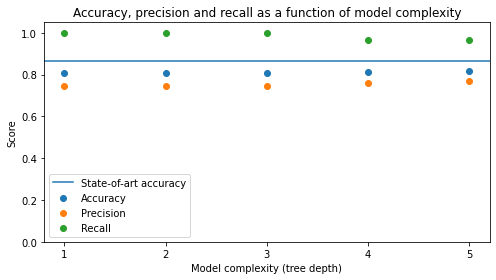

In [80]:
plot_metrics(twibot_one_hot[shared_columns], twibot_labels, soa_accuracy=0.8664)

In [81]:
# Fit and score on random forest
rf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clf, *_ = fit_and_score(twibot_one_hot[shared_columns], twibot_labels, method=rf)

Accuracy: 1.0
Precision 1.0
Recall: 1.0
F1: 1.0


In [82]:
score(rf_clf, twibot_one_hot_test[shared_columns], twibot_labels_test, method=rf)

Accuracy: 0.8047337278106509
Precision 0.7585335018963337
Recall: 0.9375
F1: 0.8385744234800838


(0.8047337278106509, 0.7585335018963337, 0.9375, 0.8385744234800838)

Starting mdi_feature_importance at 1654294464.8299327
Finished mdi_feature_importance at 1654294464.886899. Execution time: 0.056966304779052734 s
Starting permutation_feature_importance at 1654294464.8873992
Finished permutation_feature_importance at 1654294478.818291. Execution time: 13.930891752243042 s


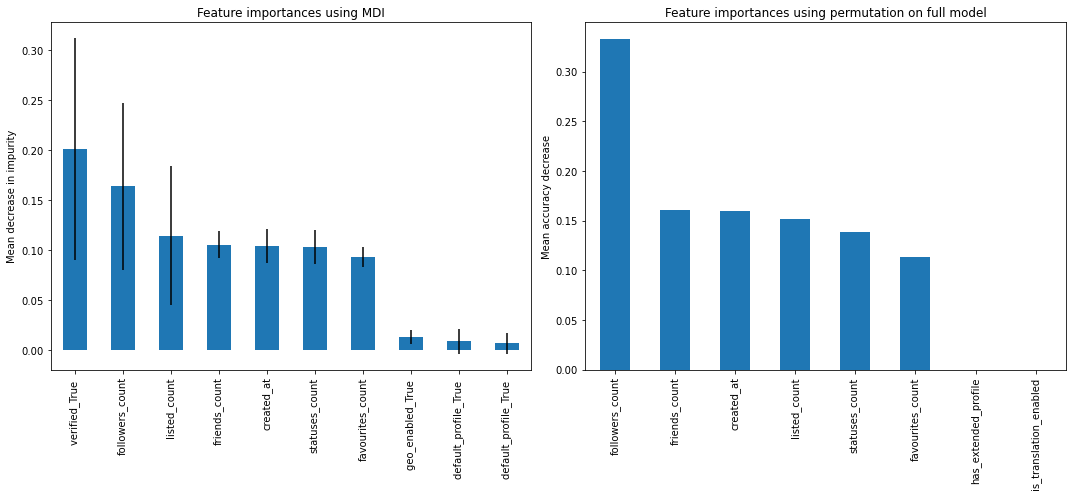

In [83]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
mdi_feature_importance(rf_clf, list(twibot_one_hot[shared_columns].columns), axes[0])
permutation_feature_importance(axes[1], twibot_df, twibot_labels, DUMMY_COLUMNS + ['is_translator', 'contributors_enabled'])
fig.tight_layout()

### Without verified

In [11]:
twibot_df, twibot_one_hot, twibot_labels = load_twibot(PROJ_PATH + "/data/Twibot-20/train.json", ['verified'])
dt_clf, *_ = fit_and_score(twibot_one_hot, twibot_labels, depth=1)

|--- listed_count <= 225.50
|   |--- weights: [1845.00, 4265.00] class: 1
|--- listed_count >  225.50
|   |--- weights: [1787.00, 381.00] class: 0

Accuracy: 0.7310944672626238
Precision 0.6980360065466449
Recall: 0.9179939733103745
F1: 0.7930457419114912


## botometer-feedback-2019: "Arming the public with artificial intelligence to counter social bots."

Yang, Kai‐Cheng, Onur Varol, Clayton A. Davis, Emilio Ferrara, Alessandro Flammini, and Filippo Menczer. "Arming the public with artificial intelligence to counter social bots." Human Behavior and Emerging Technologies 1, no. 1 (2019): 48-61.

https://arxiv.org/pdf/1901.00912.pdf

Approx. citations: 300

Precision is `# correctly predicted bots / # predicted bots`. 

Recall is `# correctly predicted bots / # bots`.

Simple decision rule precision/recall: 0.86/0.68

State-of-art precision/recall: 0.84/0.7

In [86]:
from sklearn.calibration import CalibratedClassifierCV
def analyze_bot_repo_dataset(data_path, labels_path, depth=5, soa_accuracy=None, soa_precision=None, soa_recall=None):
    profs = extract_users(data_path)
    df, one_hot, labels = preprocess_users(profs, labels_path)
    # Fit and score on decision tree
    print("-------------- DECISION TREE --------------")
#     dt_clf, *_ = fit_and_score(one_hot, labels, depth=depth)
# #    plot_metrics(one_hot, labels, soa_accuracy=soa_accuracy, soa_precision=soa_precision, soa_recall=soa_recall)
#     humans = len([lab for lab in labels if lab == 0])
#     bots = len([lab for lab in labels if lab == 1])
#     print(humans, bots)
#     # Fit and score on decision tree
#     print("-------------- DECISION TREE TRAIN/TEST SPLIT --------------")
    train_test_fit_and_score(one_hot, labels, depth=depth)
#     # Fit and score on random forest
    print("-------------- RANDOM FOREST --------------")
    train, test, train_labels, test_labels = train_test_split(one_hot, labels, test_size=0.3)
    rf = ensemble.RandomForestClassifier(n_estimators=100)
    clf_sig = CalibratedClassifierCV(rf, method='sigmoid')
    clf = fit(train, train_labels, rf)
    probs = clf.predict_proba(test)
    preds = [0 if p[0] >= 0.5 else 1 for p in probs]
    print("Accuracy score:", accuracy_score(test_labels, preds))
    print("Precision score:", precision_score(test_labels, preds))
    print("Recall score:", recall_score(test_labels, preds))
    print("F1 score:", f1_score(test_labels, preds))
    #train_test_fit_and_score(one_hot, labels, method=clf_sig)
    #fig, axes = plt.subplots(1,2, figsize=(15,7))
    #mdi_feature_importance(rf_clf, list(one_hot.columns), axes[0])
    #permutation_feature_importance(axes[1], df, labels, DUMMY_COLUMNS + ['is_translator', 'contributors_enabled'])
    #fig.tight_layout()
    return [kfold_cv(one_hot, labels, depth=i) for i in range(1,6)]

botometer_feedback_scores = analyze_bot_repo_dataset(PROJ_PATH + "/data/botometer-feedback-2019_tweets.json", PROJ_PATH + "/data/botometer-feedback-2019.tsv", depth=3, soa_precision=0.84, soa_recall=0.7)


-------------- DECISION TREE --------------
Starting train_test_fit_and_score at 1654372639.5197766
|--- friends_count <= 8.50
|   |--- favourites_count <= 70.00
|   |   |--- time_zone_Atlantic Time (Canada) <= 0.50
|   |   |   |--- weights: [0.00, 18.00] class: 1.0
|   |   |--- time_zone_Atlantic Time (Canada) >  0.50
|   |   |   |--- weights: [1.00, 0.00] class: 0.0
|   |--- favourites_count >  70.00
|   |   |--- time_zone_Mumbai <= 0.50
|   |   |   |--- weights: [2.00, 0.00] class: 0.0
|   |   |--- time_zone_Mumbai >  0.50
|   |   |   |--- weights: [0.00, 1.00] class: 1.0
|--- friends_count >  8.50
|   |--- friends_count <= 5276.00
|   |   |--- statuses_count <= 16.00
|   |   |   |--- weights: [7.00, 11.00] class: 1.0
|   |   |--- statuses_count >  16.00
|   |   |   |--- weights: [235.00, 36.00] class: 0.0
|   |--- friends_count >  5276.00
|   |   |--- created_at <= 1343924288.00
|   |   |   |--- weights: [12.00, 4.00] class: 0.0
|   |   |--- created_at >  1343924288.00
|   |   |   

In [87]:
botometer_feedback_scores

[[0.7708364451082899,
  0.8414285714285714,
  0.1765229885057471,
  0.28911137805464837],
 [0.7417102315160568,
  0.6273809523809524,
  0.26428104575163397,
  0.3346026410448766],
 [0.7976848394324123,
  0.6888969154913427,
  0.4743781512605042,
  0.554959683921948],
 [0.7919529499626587,
  0.6407429058579953,
  0.4803030303030303,
  0.5434845750187537],
 [0.7744772218073189,
  0.5945170312410293,
  0.5282417582417582,
  0.5541079610045128]]

### "Rtbust-2019: Exploiting temporal patterns for botnet detection on twitter."

Mazza, Michele, Stefano Cresci, Marco Avvenuti, Walter Quattrociocchi, and Maurizio Tesconi. "Rtbust: Exploiting temporal patterns for botnet detection on twitter." In Proceedings of the 10th ACM Conference on Web Science, pp. 183-192. 2019.

https://arxiv.org/abs/1902.04506

Approx. citations: 100

Simple decision rule accuracy: 0.7345

State-of-art accuracy: 0.8755 (using different features)

-------------- DECISION TREE --------------
|--- favourites_count <= 9206.00
|   |--- weights: [160.00, 299.00] class: 1.0
|--- favourites_count >  9206.00
|   |--- weights: [180.00, 54.00] class: 0.0

Accuracy: 0.6911976911976911
Precision 0.6514161220043573
Recall: 0.8470254957507082
F1: 0.7364532019704434
340 353


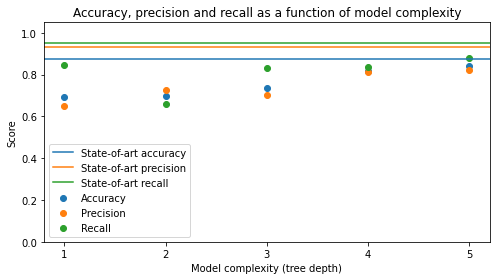

In [85]:
profs = extract_users(PROJ_PATH + "/data/cresci-rtbust-2019_tweets.json")
df, one_hot, labels = preprocess_users(profs, PROJ_PATH + "/data/cresci-rtbust-2019.tsv")
# Fit and score on decision tree
print("-------------- DECISION TREE --------------")
dt_clf, *_ = fit_and_score(one_hot, labels, depth=1)
plot_metrics(one_hot, labels, soa_accuracy=0.8755, soa_precision=0.9304, soa_recall=0.9512)
humans = len([lab for lab in labels if lab == 0])
bots = len([lab for lab in labels if lab == 1])
print(humans, bots)

In [86]:
rtbust_scores = analyze_bot_repo_dataset(PROJ_PATH + "/data/cresci-rtbust-2019_tweets.json", PROJ_PATH + "/data/cresci-rtbust-2019.tsv", depth=2, soa_accuracy=0.8755)

-------------- DECISION TREE --------------
|--- favourites_count <= 9206.00
|   |--- created_at <= 1403440128.00
|   |   |--- weights: [72.00, 66.00] class: 0.0
|   |--- created_at >  1403440128.00
|   |   |--- weights: [88.00, 233.00] class: 1.0
|--- favourites_count >  9206.00
|   |--- favourites_count <= 24401.50
|   |   |--- weights: [86.00, 41.00] class: 0.0
|   |--- favourites_count >  24401.50
|   |   |--- weights: [94.00, 13.00] class: 0.0

Accuracy: 0.6998556998556998
Precision 0.7258566978193146
Recall: 0.660056657223796
F1: 0.6913946587537092
340 353
-------------- DECISION TREE TRAIN/TEST SPLIT --------------
Starting train_test_fit_and_score at 1654294498.2273502
|--- favourites_count <= 9148.50
|   |--- listed_count <= 33.00
|   |   |--- weights: [87.00, 205.00] class: 1.0
|   |--- listed_count >  33.00
|   |   |--- weights: [14.00, 3.00] class: 0.0
|--- favourites_count >  9148.50
|   |--- favourites_count <= 14210.50
|   |   |--- weights: [31.00, 21.00] class: 0.0
|   

In [57]:
rtbust_scores

[[0.6796303103502599,
  0.6417692167274922,
  0.8385404715965766,
  0.7248570817152169],
 [0.669579372997952,
  0.6741393525890462,
  0.7227873300408512,
  0.686792348918745],
 [0.6853436958462427,
  0.6918343076190104,
  0.6782528957528957,
  0.6839277268180879],
 [0.7142677099196555,
  0.6958571361558481,
  0.7878906342690364,
  0.736841159947592],
 [0.7086383447986137,
  0.7002994483431981,
  0.7658089143977106,
  0.7264522217734173]]

## midterm-2018

Note: Too big to run on my computer right now.

In [87]:
def midterm_extract_users(data_path):
    with open(data_path) as f:
        d = json.load(f)
    return d

def midterm_preprocess_users(profs, labels_path, dummy_cols):
    df = pd.DataFrame(profs).set_index("user_id")
    df["user_created_at"] = df["user_created_at"].apply(lambda dt: datetime.strptime(dt, "%a %b %d %H:%M:%S %Y").timestamp())
    labels = pd.read_csv(labels_path, sep="\t", header=None, names=["id", "label_str"], index_col="id")
    labels.loc[labels['label_str']=="human", 'label'] = 0
    labels.loc[labels['label_str']=="bot", 'label'] = 1
    df, labels = df.align(labels, join="inner", axis=0)
    df.reset_index(inplace=True)
    labels = labels['label']
    one_hot = preprocess(df, ['probe_timestamp', 'screen_name', 'name', 'description', 'url'], dummy_cols)
    return df, one_hot, labels

def analyze_midterm_dataset(data_path, labels_path, depth=1, soa_accuracy=None, soa_precision=None, soa_recall=None):
    profs = midterm_extract_users(data_path)
    dummy_cols = ['lang', 'protected', 'verified', 'geo_enabled', 'profile_use_background_image', 'default_profile', 'index']
    df, one_hot, labels = midterm_preprocess_users(profs, labels_path, dummy_cols)
    # Fit and score on decision tree
    print("-------------- DECISION TREE --------------")
    dt_clf, *_ = fit_and_score(one_hot, labels, depth=depth)
#    plot_metrics(one_hot, labels, soa_accuracy=soa_accuracy, soa_precision=soa_precision, soa_recall=soa_recall)
    # Fit and score on decision tree
#     print("-------------- DECISION TREE TRAIN/TEST SPLIT --------------")
#     train_test_fit_and_score(one_hot, labels, depth=depth)
#     # Fit and score on random forest
#     print("-------------- RANDOM FOREST --------------")
#     rf = ensemble.RandomForestClassifier(n_estimators=100)
#     rf_clf, *_ = fit_and_score(one_hot, labels, method=rf)
#     fig, axes = plt.subplots(1,2, figsize=(15,7))
#     mdi_feature_importance(rf_clf, list(one_hot.columns), axes[0])
#     permutation_feature_importance(axes[1], df, labels, dummy_cols)
#     fig.tight_layout()
    return [kfold_cv(one_hot, labels, depth=i) for i in range(1,6)]

midterm2018_scores = analyze_midterm_dataset(PROJ_PATH + "/data/midterm-2018/midterm-2018_processed_user_objects.json", PROJ_PATH + "/data/midterm-2018/midterm-2018.tsv", depth=1)

-------------- DECISION TREE --------------
|--- user_created_at <= 1505082048.00
|   |--- weights: [7396.00, 584.00] class: 0.0
|--- user_created_at >  1505082048.00
|   |--- weights: [696.00, 41862.00] class: 1.0

Accuracy: 0.9746725236455737
Precision 0.9836458480191739
Recall: 0.9862413419403477
F1: 0.9849418850877606
Starting kfold_cv at 1654294584.450772
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654294744.7488832. Execution time: 160.29811120033264 s
Starting kfold_cv at 1654294744.7492192
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654294947.751152. Execution time: 203.00193285942078 s
Starting kfold_cv at 1654294947.752092
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654295182.3981934. Execution time: 234.64610147476196 s
Starting kfold_cv at 1654295182.3990035


In [88]:
midterm2018_scores

[[0.9746725313184008,
  0.9836441063938995,
  0.9862434846629601,
  0.9849409270176954],
 [0.9835965281666883,
  0.9877493959427837,
  0.9927899696310531,
  0.9902596177793761],
 [0.9862678128654622,
  0.9879194505138035,
  0.9958288965363277,
  0.9918570258429675],
 [0.9894930554484163,
  0.9898563326966228,
  0.9977141662829292,
  0.9937695808423822],
 [0.9903043293130803,
  0.9898202075913807,
  0.9987292937085497,
  0.994254458325902]]

In [73]:
profs = midterm_extract_users(PROJ_PATH + "/data/midterm-2018/midterm-2018_processed_user_objects.json")
dummy_cols = ['lang', 'protected', 'verified', 'geo_enabled', 'profile_use_background_image', 'default_profile', 'index']
df, one_hot, labels = midterm_preprocess_users(profs, PROJ_PATH + "/data/midterm-2018/midterm-2018.tsv", dummy_cols)
rf = ensemble.RandomForestClassifier(n_estimators=100)
train_test_fit_and_score(one_hot, labels, method=rf)

Starting train_test_fit_and_score at 1653954240.866365
|--- user_created_at <= 1504892608.00
|   |--- tid <= 1060283183200731136.00
|   |   |--- favourites_count <= 18.50
|   |   |   |--- weights: [72.00, 61.00] class: 0.0
|   |   |--- favourites_count >  18.50
|   |   |   |--- weights: [5057.00, 13.00] class: 0.0
|   |--- tid >  1060283183200731136.00
|   |   |--- weights: [0.00, 338.00] class: 1.0
|--- user_created_at >  1504892608.00
|   |--- favourites_count <= 1552.50
|   |   |--- geo_enabled_True <= 0.50
|   |   |   |--- weights: [286.00, 29054.00] class: 1.0
|   |   |--- geo_enabled_True >  0.50
|   |   |   |--- weights: [53.00, 101.00] class: 1.0
|   |--- favourites_count >  1552.50
|   |   |--- user_created_at <= 1535756288.00
|   |   |   |--- weights: [163.00, 60.00] class: 0.0
|   |   |--- user_created_at >  1535756288.00
|   |   |   |--- weights: [8.00, 110.00] class: 1.0

Accuracy: 0.9871388998812821
Precision 0.9895931142410016
Recall: 0.9951215673931859
F1: 0.99234964102

## gilani-2017

In [11]:
gilani_scores = analyze_bot_repo_dataset(PROJ_PATH + "/data/gilani-2017_tweets.json", PROJ_PATH + "/data/gilani-2017.tsv", depth=3, soa_accuracy=0.8755)

-------------- DECISION TREE --------------
|--- statuses_count <= 90439.00
|   |--- favourites_count <= 1471.50
|   |   |--- statuses_count <= 34842.50
|   |   |   |--- weights: [321.00, 180.00] class: 0.0
|   |   |--- statuses_count >  34842.50
|   |   |   |--- weights: [90.00, 171.00] class: 1.0
|   |--- favourites_count >  1471.50
|   |   |--- statuses_count <= 50663.00
|   |   |   |--- weights: [710.00, 145.00] class: 0.0
|   |   |--- statuses_count >  50663.00
|   |   |   |--- weights: [167.00, 96.00] class: 0.0
|--- statuses_count >  90439.00
|   |--- favourites_count <= 3001.00
|   |   |--- has_extended_profile_True <= 0.50
|   |   |   |--- weights: [10.00, 264.00] class: 1.0
|   |   |--- has_extended_profile_True >  0.50
|   |   |   |--- weights: [16.00, 55.00] class: 1.0
|   |--- favourites_count >  3001.00
|   |   |--- statuses_count <= 142930.50
|   |   |   |--- weights: [67.00, 56.00] class: 0.0
|   |   |--- statuses_count >  142930.50
|   |   |   |--- weights: [32.00, 123

In [78]:
gilani_scores

[[0.7103388413553654,
  0.7884492335823218,
  0.45791174922277655,
  0.5791332877058186],
 [0.7119500478001912,
  0.765294843847512,
  0.4966305330497748,
  0.5979082606256532],
 [0.7331349325397302,
  0.7659048835296934,
  0.5715213382615072,
  0.6497206390550103],
 [0.7323205292821171,
  0.7160816429465366,
  0.6441558694967064,
  0.675848915400908],
 [0.7406701626806507,
  0.7528569995260148,
  0.6027759942766246,
  0.6691609415965379]]

In [81]:
profs = extract_users(PROJ_PATH + "/data/gilani-2017_tweets.json")
df, one_hot, labels = preprocess_users(profs, PROJ_PATH + "/data/gilani-2017.tsv")
df.T

,0,1,2,3,4,5,6,7,8,9,...,2493,2494,2495,2496,2497,2498,2499,2500,2501,2502
location,In your Xbox,"Seattle, WA",🏴󠁧󠁢󠁷󠁬󠁳󠁿,NYC - Boston - Chicago - SF,"University of Regina, Canada.","London, UK",,Internet,🇯🇵 ⇄ 🇲🇽 ⇄ 🇺🇸,"Londres, GB, e São Paulo, BR",...,"Muara Bungo, Indonesia",Mystic Falls.,United Kingdom,,,لا اله الا الله,06.08🤞,Activa mis notificaciones 🔔,,"Rocha, Uruguay"
protected,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
followers_count,1127687,11426282,176975,1170497,128848,24393975,41183185,116023,110236,2090741,...,5,1,17,9365,65,3,88,276,51,73
friends_count,5,96424,230,1113,69934,92,1111,23767,2605,906,...,44,8,13,56,23,11,99,12,118,15
listed_count,11593,28442,1122,29281,4385,112307,137121,7072,1913,7342,...,0,0,0,74,0,0,0,0,0,0
created_at,1164227283.0,1164827942.0,1168443543.0,1169949529.0,1170268203.0,1170315869.0,1170981302.0,1171287495.0,1171881280.0,1172233646.0,...,1528580175.0,1530229417.0,1531252672.0,1535355982.0,1536404088.0,1536669160.0,1538627827.0,1542127115.0,1545401958.0,1546197271.0
favourites_count,7,17340,10641,6185,27504,10,1449,46789,9415,398,...,0,2,25,25,0,3,1626,22,1,220
utc_offset,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
time_zone,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
geo_enabled,True,True,True,False,True,True,True,True,True,True,...,False,False,False,False,False,False,True,False,False,True


In [82]:
one_hot.T

,0,1,2,3,4,5,6,7,8,9,...,2493,2494,2495,2496,2497,2498,2499,2500,2501,2502
followers_count,1.127687e+06,1.142628e+07,1.769750e+05,1.170497e+06,1.288480e+05,2.439398e+07,4.118318e+07,1.160230e+05,1.102360e+05,2.090741e+06,...,5.000000e+00,1.000000e+00,1.700000e+01,9.365000e+03,6.500000e+01,3.000000e+00,8.800000e+01,2.760000e+02,5.100000e+01,7.300000e+01
friends_count,5.000000e+00,9.642400e+04,2.300000e+02,1.113000e+03,6.993400e+04,9.200000e+01,1.111000e+03,2.376700e+04,2.605000e+03,9.060000e+02,...,4.400000e+01,8.000000e+00,1.300000e+01,5.600000e+01,2.300000e+01,1.100000e+01,9.900000e+01,1.200000e+01,1.180000e+02,1.500000e+01
listed_count,1.159300e+04,2.844200e+04,1.122000e+03,2.928100e+04,4.385000e+03,1.123070e+05,1.371210e+05,7.072000e+03,1.913000e+03,7.342000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,7.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
created_at,1.164227e+09,1.164828e+09,1.168444e+09,1.169950e+09,1.170268e+09,1.170316e+09,1.170981e+09,1.171287e+09,1.171881e+09,1.172234e+09,...,1.528580e+09,1.530229e+09,1.531253e+09,1.535356e+09,1.536404e+09,1.536669e+09,1.538628e+09,1.542127e+09,1.545402e+09,1.546197e+09
favourites_count,7.000000e+00,1.734000e+04,1.064100e+04,6.185000e+03,2.750400e+04,1.000000e+01,1.449000e+03,4.678900e+04,9.415000e+03,3.980000e+02,...,0.000000e+00,2.000000e+00,2.500000e+01,2.500000e+01,0.000000e+00,3.000000e+00,1.626000e+03,2.200000e+01,1.000000e+00,2.200000e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
verified_True,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
profile_use_background_image_True,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
is_translator_True,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
is_translation_enabled_True,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [48]:
# Fit and score on decision tree
print("-------------- DECISION TREE --------------")
dt_clf, *_ = fit_and_score(one_hot, labels, depth=3)
#    plot_metrics(one_hot, labels, soa_accuracy=soa_accuracy, soa_precision=soa_precision, soa_recall=soa_recall)
humans = len([lab for lab in labels if lab == 0])
bots = len([lab for lab in labels if lab == 1])
print(humans, bots)
# Fit and score on decision tree
print("-------------- DECISION TREE TRAIN/TEST SPLIT --------------")
train_test_fit_and_score(one_hot, labels, depth=3)
# Fit and score on random forest
print("-------------- RANDOM FOREST --------------")
rf = ensemble.RandomForestClassifier(n_estimators=100)
train_test_fit_and_score(one_hot, labels, method=rf)
#fig, axes = plt.subplots(1,2, figsize=(15,7))
#mdi_feature_importance(rf_clf, list(one_hot.columns), axes[0])
#permutation_feature_importance(axes[1], df, labels, DUMMY_COLUMNS + ['is_translator', 'contributors_enabled'])
#fig.tight_layout()
gilani_scores = [kfold_cv(one_hot, labels, depth=i) for i in range(1,6)]

-------------- DECISION TREE --------------


NameError: name 'one_hot' is not defined

## Giliani using the derived features in the paper

In [64]:
sizes = ['100k', '10M', '1k', '1M']

humans_dfs = []
bots_dfs = []

for s in sizes:
    human_path = PROJ_PATH + f"/data/gilani_derived/classification_processed/humans/humans.{s}.csv"
    human_df = pd.read_csv(human_path)
    bot_path = PROJ_PATH + f"/data/gilani_derived/classification_processed/bots/bots.{s}.csv"
    bots_df = pd.read_csv(bot_path)
    for band in sizes:
        if band == s:
            human_df[f'band_{band}'] = 1
            bots_df[f'band_{band}'] = 1
        else:
            human_df[f'band_{band}'] = 0
            bots_df[f'band_{band}'] = 0
    humans_dfs.append(human_df)
    bots_dfs.append(bots_df)
    
humans = pd.concat(humans_dfs)
bots = pd.concat(bots_dfs)
gilani_processed = pd.concat([humans, bots])

labels = [0]*len(humans) + [1]*len(bots)


gilani_processed['source_identity_list'] = gilani_processed['source_identity'].apply(lambda s: s[1:-1].split(sep=';'))
for i in range(7):
    gilani_processed[f'source{i}'] = gilani_processed['source_identity_list'].apply(lambda x: 1 if f'{i}' in x else 0)

    
gilani_processed.drop(['screen_name', 'source_identity', 'source_identity_list'], axis=1, inplace=True)
# Fit and score on decision tree
# print("-------------- DECISION TREE TRAIN/TEST SPLIT --------------")
train_test_fit_and_score(gilani_processed, labels, depth=5)
# # Fit and score on random forest
# print("-------------- RANDOM FOREST --------------")
rf = ensemble.RandomForestClassifier(n_estimators=100)
train_test_fit_and_score(gilani_processed, labels, method=rf)
# fig, axes = plt.subplots(1,2, figsize=(15,7))
# mdi_feature_importance(rf_clf, list(gilani_processed.columns), axes[0])
# permutation_feature_importance(axes[1], gilani_processed, labels, [])
# fig.tight_layout()
# return [kfold_cv(one_hot, labels, depth=i) for i in range(1,6)]

Starting train_test_fit_and_score at 1654371088.5531774
|--- source2 <= 0.50
|   |--- tweet_frequency <= 22.47
|   |   |--- source1 <= 0.50
|   |   |   |--- weights: [68.00, 165.00] class: 1
|   |   |--- source1 >  0.50
|   |   |   |--- weights: [91.00, 45.00] class: 0
|   |--- tweet_frequency >  22.47
|   |   |--- cdn_content_in_kb <= 0.59
|   |   |   |--- weights: [8.00, 267.00] class: 1
|   |   |--- cdn_content_in_kb >  0.59
|   |   |   |--- weights: [23.00, 74.00] class: 1
|--- source2 >  0.50
|   |--- tweet_frequency <= 33.22
|   |   |--- source0 <= 0.50
|   |   |   |--- weights: [859.00, 115.00] class: 0
|   |   |--- source0 >  0.50
|   |   |   |--- weights: [105.00, 85.00] class: 0
|   |--- tweet_frequency >  33.22
|   |   |--- lists_per_user <= 0.01
|   |   |   |--- weights: [86.00, 35.00] class: 0
|   |   |--- lists_per_user >  0.01
|   |   |   |--- weights: [116.00, 259.00] class: 1

Accuracy: 0.7786407766990291
Precision 0.7505720823798627
Recall: 0.7337807606263982
F1: 0.74

In [63]:
gilani_processed_scores = [kfold_cv(gilani_processed, pd.Series(labels), depth=i) for i in range(1,6)]

Starting kfold_cv at 1654371040.660688
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654371040.8081193. Execution time: 0.1474313735961914 s
Starting kfold_cv at 1654371040.8094006
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654371040.9124568. Execution time: 0.10305619239807129 s
Starting kfold_cv at 1654371040.913722
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654371041.0103953. Execution time: 0.09667325019836426 s
Starting kfold_cv at 1654371041.0116565
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654371041.1422048. Execution time: 0.13054823875427246 s
Starting kfold_cv at 1654371041.144018
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfol

In [60]:
gilani_processed_scores

[[0.7146517312737496,
  0.7399725095471126,
  0.5315176930019714,
  0.6182322430238263],
 [0.7493240924852043,
  0.6885147102334717,
  0.7802522912097902,
  0.7304597175458191],
 [0.7787989028624038,
  0.7741218072585587,
  0.7004816820483153,
  0.732191414070224],
 [0.7814121703845309,
  0.7732873526613651,
  0.7067324249170973,
  0.7369643314017857],
 [0.7924935158486086,
  0.7755556477406139,
  0.7318878305077099,
  0.7528028219863963]]

## cresci-2017: "The paradigm-shift of social spambots: Evidence, theories, and tools for the arms race."

Cresci, S., Di Pietro, R., Petrocchi, M., Spognardi, A., & Tesconi, M. (2017, April). The paradigm-shift of social spambots: Evidence, theories, and tools for the arms race. In Proceedings of the 26th International Conference on World Wide Web Companion (pp. 963-972). ACM.

https://arxiv.org/abs/1701.03017

Approx. citations: 328

Simple decision rule precision/recall: 0.98/0.98

State-of-art precision/recall: 0.98/0.98

In [91]:
# Load in data
folder_names = ['fake_followers', 
 'genuine_accounts', 
 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1', 
 'traditional_spambots_2', 
 'traditional_spambots_3',
 'traditional_spambots_4']
is_bot = [1, 0, 1, 1, 1, 1, 1, 1, 1]
dfs = []
cresci2017_labels = []

for name, ib in zip(folder_names, is_bot):
    df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/users.csv")
    dfs.append(df)
    cresci2017_labels.extend([ib]*len(df))

    
def format_time(dt):
    try:
        datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y").timestamp()
    except:
        print(dt)
    
cresci2017 = pd.concat(dfs)
cresci2017_labels = pd.Series(cresci2017_labels)



# Preprocess
cresci2017_one_hot = preprocess(cresci2017, 
                        COLUMNS_TO_DROP + ['profile_banner_url', 
                                                        'test_set_1', 
                                                        'test_set_2', 
                                                        'crawled_at',
                                                        'updated', 
                                                        'timestamp',
                                                        'following', 
                                                        'follow_request_sent',
                                                        'created_at'
                                                  ], 
                        DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications'])

# Fit and score decision tree
fit_and_score(cresci2017_one_hot, cresci2017_labels, depth=1)

|--- favourites_count <= 16.50
|   |--- weights: [186.00, 10744.00] class: 1
|--- favourites_count >  16.50
|   |--- weights: [3288.00, 150.00] class: 0

Accuracy: 0.9766146993318485
Precision 0.9829826166514181
Recall: 0.9862309528180649
F1: 0.9846041055718475


(DecisionTreeClassifier(max_depth=1),
 0.9766146993318485,
 0.9829826166514181,
 0.9862309528180649,
 0.9846041055718475)

In [92]:
cresci2017_scores = [kfold_cv(cresci2017_one_hot, cresci2017_labels, depth=i) for i in range(1,6)]

Starting kfold_cv at 1654296189.386692
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654296193.808518. Execution time: 4.421825885772705 s
Starting kfold_cv at 1654296193.8087606
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654296199.3144586. Execution time: 5.505697965621948 s
Starting kfold_cv at 1654296199.314597
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654296205.3795807. Execution time: 6.06498384475708 s
Starting kfold_cv at 1654296205.3797197
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654296212.0015125. Execution time: 6.621792793273926 s
Starting kfold_cv at 1654296212.001628
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1

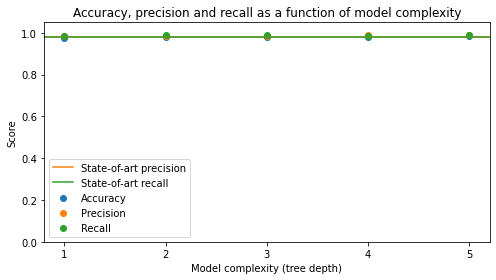

In [16]:
plot_metrics(cresci2017_one_hot, cresci2017_labels, soa_precision=0.98, soa_recall=0.98)

In [17]:
train_test_fit_and_score(cresci2017_one_hot, cresci2017_labels, depth=1)

|--- favourites_count <= 16.50
|   |--- weights: [127.00, 7510.00] class: 1
|--- favourites_count >  16.50
|   |--- weights: [2315.00, 105.00] class: 0

Accuracy: 0.9758756668986314
Precision 0.9820832068023079
Recall: 0.9862763037511436
F1: 0.9841752891052952


In [18]:
# Fit and score on random forest
rf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clf, *_ = fit_and_score(cresci2017_one_hot, cresci2017_labels, method=rf)

Accuracy: 1.0
Precision 1.0
Recall: 1.0
F1: 1.0


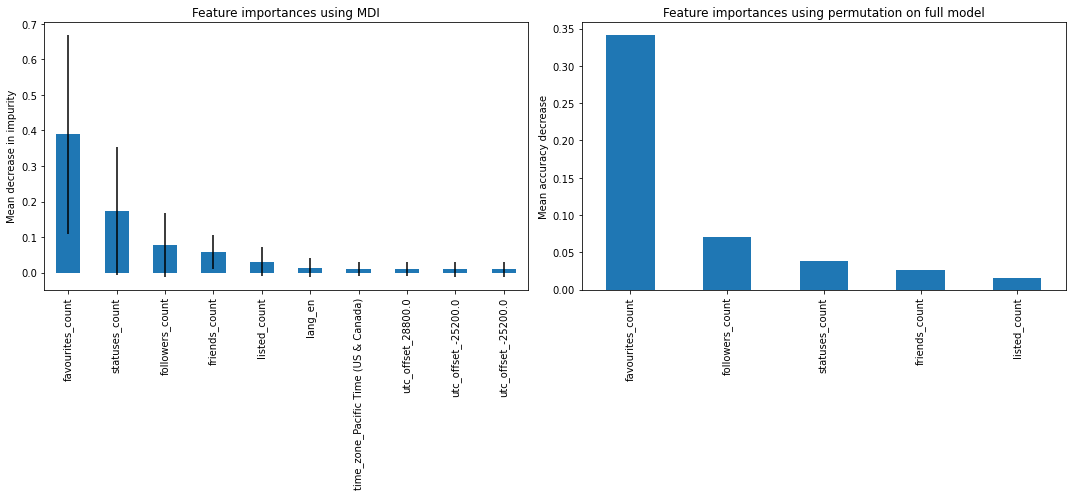

In [19]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
mdi = mdi_feature_importance(rf_clf, list(cresci2017_one_hot.columns), axes[0])
permutation_feature_importance(axes[1], cresci2017, cresci2017_labels, DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications',])
fig.tight_layout()

## varol-2017

Bot repository only has account ids and labels. Reached out to http://sbp-brims.org/2021/papers/working-papers/2021_SBP-BRiMS_FinalPDF_57.pdf to get full data.

In [67]:
varol = np.loadtxt(PROJ_PATH + "/data/gilani_derived/varol-2017.dat", unpack=True)

In [68]:
varol

array([[3.09842135e+09, 5.54067867e+08, 2.56597786e+08, ...,
        3.52864520e+09, 3.39406006e+09, 1.68603364e+09],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## cresci-2015

In [93]:
folder_names = ["elzioni2013", "TheFakeProject", "intertwitter", "twittertechnology", "fastfollowerz"]
is_bot = [0, 0, 1, 1, 1]

dfs = []
cresci2015_labels = []

for name, ib in zip(folder_names, is_bot):
    df = pd.read_csv(PROJ_PATH + f"/data/cresci-2015/{name}/users.csv")
    #print(name, df["created_at"])
    dfs.append(df)
    cresci2015_labels.extend([ib]*len(df))

cresci2015 = pd.concat(dfs)
cresci2015["created_at"] = cresci2015["created_at"].apply(lambda dt: datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y").timestamp())
cresci2015_labels = pd.Series(cresci2015_labels)


# Preprocess
cresci2015_one_hot = preprocess(cresci2015, 
                        ['id', 'lang', 'name', 'screen_name',
                           'url', 'profile_image_url',
                           'profile_banner_url',
                           'profile_background_image_url_https', 'profile_text_color',
                           'profile_image_url_https', 'profile_sidebar_border_color',
                           'profile_sidebar_fill_color',
                           'profile_background_image_url', 'profile_background_color',
                           'profile_link_color',
                           'description', 'dataset', 'updated'], 
                        [col for col in DUMMY_COLUMNS if col not in ['lang']])


# Fit and score decision tree
fit_and_score(cresci2015_one_hot, cresci2015_labels, depth=1)

|--- statuses_count <= 78.50
|   |--- weights: [210.00, 3140.00] class: 1
|--- statuses_count >  78.50
|   |--- weights: [1740.00, 211.00] class: 0

Accuracy: 0.9205810224485946
Precision 0.9373134328358209
Recall: 0.9370337212772307
F1: 0.937173556185644


(DecisionTreeClassifier(max_depth=1),
 0.9205810224485946,
 0.9373134328358209,
 0.9370337212772307,
 0.937173556185644)

In [94]:
cresci2015_scores = [kfold_cv(cresci2015_one_hot, cresci2015_labels, depth=i) for i in range(1,6)]

Starting kfold_cv at 1654296222.8643372
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654296224.2288291. Execution time: 1.3644919395446777 s
Starting kfold_cv at 1654296224.2295697
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654296225.8177483. Execution time: 1.5881786346435547 s
Starting kfold_cv at 1654296225.8178644
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654296227.6689143. Execution time: 1.8510499000549316 s
Starting kfold_cv at 1654296227.6690366
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654296229.2699306. Execution time: 1.6008939743041992 s
Starting kfold_cv at 1654296229.2700634
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfol

In [37]:
cresci2015_scores

[[0.9198219847576009,
  0.9350080816088513,
  0.9382363274723101,
  0.9365960530858823],
 [0.9249172296890619,
  0.9881081984393514,
  0.8918086098271567,
  0.9374589673717992],
 [0.968319635623379,
  0.9878506799744852,
  0.9619461454476319,
  0.974606416849117],
 [0.9788685813440668,
  0.9864565448326269,
  0.9799469626483022,
  0.9831761704577264],
 [0.9807578755516163,
  0.9871383707803822,
  0.9823941080381671,
  0.9847544117759506]]

In [21]:
train_test_fit_and_score(cresci2015_one_hot, cresci2015_labels, depth=2)

|--- statuses_count <= 78.50
|   |--- friends_count <= 159.50
|   |   |--- weights: [117.00, 99.00] class: 0
|   |--- friends_count >  159.50
|   |   |--- weights: [23.00, 2105.00] class: 1
|--- statuses_count >  78.50
|   |--- friends_count <= 474.50
|   |   |--- weights: [925.00, 19.00] class: 0
|   |--- friends_count >  474.50
|   |   |--- weights: [288.00, 134.00] class: 0

Accuracy: 0.9226901319924575
Precision 0.9943246311010215
Recall: 0.8812877263581489
F1: 0.9343999999999999


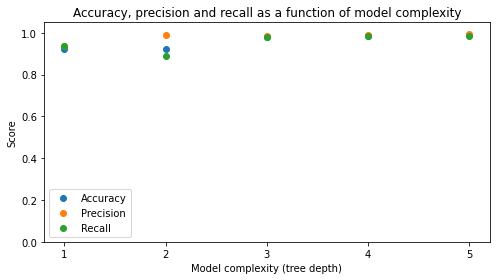

In [22]:
plot_metrics(cresci2015_one_hot, cresci2015_labels)

## caverlee-2011: "A Long-Term Study of Content Polluters on Twitter."

Lee, Kyumin, Brian David Eoff, and James Caverlee. "A Long-Term Study of Content Polluters on Twitter." ICWSM. 2011.

https://ojs.aaai.org/index.php/ICWSM/article/view/14106

Approx. citations: 500

Simple decision rule precision/recall: 0.91/0.92

State-of-art precision/recall: 0.89/0.87

In [95]:
caverlee2011_bots = pd.read_csv(PROJ_PATH + "/data/social_honeypot_icwsm_2011/content_polluters.txt", sep="\t", header=None, names=["UserID", "CreatedAt", "CollectedAt", "NumerOfFollowings", "NumberOfFollowers", "NumberOfTweets", "LengthOfScreenName", "LengthOfDescriptionInUserProfile"])
caverlee2011_humans = pd.read_csv(PROJ_PATH + "/data/social_honeypot_icwsm_2011/legitimate_users.txt", sep="\t", header=None, names=["UserID", "CreatedAt", "CollectedAt", "NumerOfFollowings", "NumberOfFollowers", "NumberOfTweets", "LengthOfScreenName", "LengthOfDescriptionInUserProfile"])
caverlee2011 = pd.concat([caverlee2011_bots, caverlee2011_humans])
caverlee2011["CreatedAt"] = caverlee2011["CreatedAt"].apply(lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").timestamp())
caverlee2011.drop(columns=["CollectedAt", "UserID"], inplace=True)
caverlee2011_labels = pd.Series([1]*len(caverlee2011_bots) + [0]*len(caverlee2011_humans))


In [96]:
fit_and_score(caverlee2011, caverlee2011_labels, depth=2)

|--- CreatedAt <= 1259512448.00
|   |--- NumerOfFollowings <= 502.50
|   |   |--- weights: [17261.00, 1879.00] class: 0
|   |--- NumerOfFollowings >  502.50
|   |   |--- weights: [2015.00, 7856.00] class: 1
|--- CreatedAt >  1259512448.00
|   |--- weights: [0.00, 12488.00] class: 1

Accuracy: 0.9061664136485217
Precision 0.9098796905049421
Recall: 0.9154479593214238
F1: 0.9126553317482392


(DecisionTreeClassifier(max_depth=2),
 0.9061664136485217,
 0.9098796905049421,
 0.9154479593214238,
 0.9126553317482392)

In [97]:
train_test_fit_and_score(caverlee2011, caverlee2011_labels)

Starting train_test_fit_and_score at 1654296235.3732343
|--- CreatedAt <= 1259508608.00
|   |--- NumerOfFollowings <= 502.50
|   |   |--- NumerOfFollowings <= 212.50
|   |   |   |--- weights: [10332.00, 541.00] class: 0
|   |   |--- NumerOfFollowings >  212.50
|   |   |   |--- weights: [1751.00, 780.00] class: 0
|   |--- NumerOfFollowings >  502.50
|   |   |--- NumberOfTweets <= 2110.50
|   |   |   |--- weights: [526.00, 4125.00] class: 1
|   |   |--- NumberOfTweets >  2110.50
|   |   |   |--- weights: [860.00, 1356.00] class: 1
|--- CreatedAt >  1259508608.00
|   |--- weights: [0.00, 8778.00] class: 1

Accuracy: 0.9045783132530121
Precision 0.9061801935964259
Recall: 0.9160018064127653
F1: 0.9110645306183561
Finished train_test_fit_and_score at 1654296235.5634406. Execution time: 0.19020628929138184 s


In [98]:
caverlee2011_scores = [kfold_cv(caverlee2011, caverlee2011_labels, depth=i) for i in range(1,6)]

Starting kfold_cv at 1654296236.8013773
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654296237.401742. Execution time: 0.6003646850585938 s
Starting kfold_cv at 1654296237.4019976
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654296238.041055. Execution time: 0.6390573978424072 s
Starting kfold_cv at 1654296238.0411196
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654296238.6715596. Execution time: 0.6304399967193604 s
Starting kfold_cv at 1654296238.6719012
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1654296239.4178927. Execution time: 0.7459914684295654 s
Starting kfold_cv at 1654296239.4182765
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_

In [42]:
caverlee2011_scores

[[0.7652715394654894,
  0.9992851460233355,
  0.562075351070636,
  0.7194555116169198],
 [0.9057085699104406,
  0.9094958450618245,
  0.9149385636764293,
  0.9122073952593454],
 [0.905997706212245,
  0.9093939864615439,
  0.9156663010853604,
  0.9125048443830268],
 [0.9292271793524259,
  0.9325992405684053,
  0.9355131535681187,
  0.9340265233764049],
 [0.9317332208699843,
  0.9252424696880027,
  0.9492626928039158,
  0.9370612065470887]]

In [26]:
train_test_fit_and_score(caverlee2011, caverlee2011_labels, depth=2)

|--- CreatedAt <= 1259513664.00
|   |--- NumerOfFollowings <= 498.50
|   |   |--- weights: [12086.00, 1317.00] class: 0
|   |--- NumerOfFollowings >  498.50
|   |   |--- weights: [1407.00, 5558.00] class: 1
|--- CreatedAt >  1259513664.00
|   |--- weights: [0.00, 8681.00] class: 1

Accuracy: 0.9057831325301204
Precision 0.9078087885985748
Recall: 0.9172041397930103
F1: 0.9124822800865479


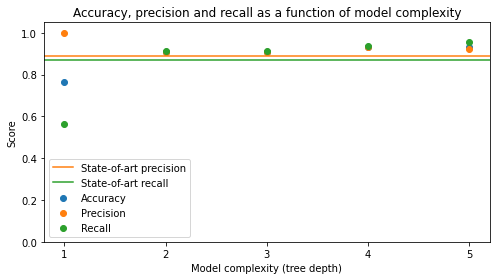

In [27]:
plot_metrics(caverlee2011, caverlee2011_labels, soa_precision=0.89, soa_recall=0.87)

In [28]:
rf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=10)
rf_clf, _, _, _, _ = fit_and_score(caverlee2011, caverlee2011_labels, method=rf, depth=2)

Accuracy: 0.9526253644666136
Precision 0.9538875196056464
Recall: 0.9578364757233497
F1: 0.9558579190803359


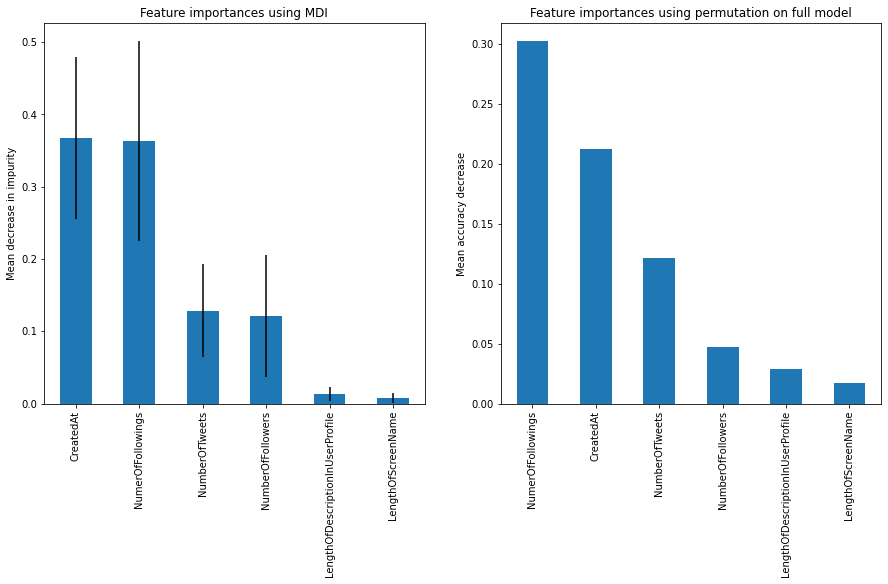

In [29]:
fig, axes =plt.subplots(1, 2, figsize=(15,7))
mdi_feature_importance(rf_clf, list(caverlee2011.columns), axes[0])
permutation_feature_importance(axes[1], caverlee2011, caverlee2011_labels, [])

## Kaiser

Only account ids and labels.

In [33]:
kaiser = pyreadr.read_r(PROJ_PATH + '/data/kaiser/data_botometer.RData')['data_botometer']

In [34]:
kaiser

,user.id_str,date,type,cap.universal,scores.universal
0,1073515275323097088,2019-03-03,bot,0.325413,0.724840
1,961438005675397120,2019-03-03,bot,0.104603,0.515643
2,941291900862124032,2019-03-03,bot,0.060559,0.413570
3,809439447796355072,2019-03-03,bot,0.060559,0.413570
4,769777732213321729,2019-03-03,bot,0.054305,0.393746
...,...,...,...,...,...
374719,2234767742,2019-06-02,ger_bot,0.104603,0.515643
374720,1092190045,2019-06-02,ger_bot,0.010165,0.170132
374721,57146860,2019-06-02,ger_bot,0.023812,0.267344
374722,56828167,2019-06-02,ger_bot,0.005778,0.119570


# Single-class datasets

## Astroturf

Only account ids and labels.

## botwiki-2019

In [36]:
botwiki_profs = extract_users(PROJ_PATH + "/data/botwiki-2019_tweets.json")
botwiki_df, botwiki_one_hot, botwiki_labels = preprocess_users(botwiki_profs, PROJ_PATH + "/data/botwiki-2019.tsv")

## celebrity-2019

In [37]:
celebrity_profs = extract_users(PROJ_PATH + "/data/celebrity-2019_tweets.json")
celebrity_df, celebrity_one_hot, celebrity_labels = preprocess_users(celebrity_profs, PROJ_PATH + "/data/celebrity-2019.tsv")

## political-bots-2019

In [38]:
political_bots_profs = extract_users(PROJ_PATH + "/data/political-bots-2019/political-bots-2019_tweets.json")
political_bots_df, political_bots_one_hot, political_bots_labels = preprocess_users(political_bots_profs, PROJ_PATH + "/data/political-bots-2019/political-bots-2019.tsv")

## pronbots-2019

In [39]:
def extract_users_list(data_path):
    with open(data_path) as f:
        d = json.load(f)
    return d

pronbots_profs = extract_users_list(PROJ_PATH + "/data/pronbots-2019_tweets.json")
pronbots_df, pronbots_one_hot, pronbots_labels = preprocess_users(pronbots_profs, PROJ_PATH + "/data/pronbots-2019.tsv")

KeyError: "None of ['id'] are in the columns"

In [39]:
pronbots_one_hot

,followers_count,friends_count,listed_count,created_at,favourites_count,statuses_count


## vendor-purchased-2019

In [40]:
vendor_purchased_profs = extract_users(PROJ_PATH + "/data/vendor-purchased-2019_tweets.json")
vendor_purchased_df, vendor_purchased_one_hot, vendor_purchased_labels = preprocess_users(vendor_purchased_profs, PROJ_PATH + "/data/vendor-purchased-2019.tsv")

## analysis of each of the specialized classifiers in Botometer

### humans

In [ ]:
human_df = pd.concat([caverlee2011_humans], axis=0)

### simple bots

In [20]:
simple_df = caverlee2011_bots

### spammers

In [28]:
# Load in cresci data
folder_names = [ 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1', 
 'traditional_spambots_2', 
 'traditional_spambots_3',
 'traditional_spambots_4']
dfs = []

for name in folder_names:
    df = pd.read_csv(f"./data/cresci-2017/{name}.csv/users.csv")
    dfs.append(df)

    
def format_time(dt):
    try:
        datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y").timestamp()
    except:
        print(dt)
    
cresci2017_spammers = pd.concat(dfs)



# Preprocess
cresci2017_one_hot = preprocess(cresci2017_spammers, 
                        COLUMNS_TO_DROP + ['profile_banner_url', 
                                                        'test_set_1', 
                                                        'test_set_2', 
                                                        'crawled_at',
                                                        'updated', 
                                                        'timestamp',
                                                        'following', 
                                                        'follow_request_sent',
                                                        'created_at'
                                                  ], 
                        DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications'])

spammers_df = pd.concat([pronbots_one_hot, cresci2017_one_hot], ignore_index=True)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [31]:
cresci2017_one_hot

,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang_en,lang_en-gb,lang_it,lang_ja,lang_nl,...,utc_offset_-14400.0,utc_offset_-7200.0,utc_offset_0.0,utc_offset_3600.0,utc_offset_7200.0,utc_offset_10800.0,utc_offset_14400.0,utc_offset_21600.0,utc_offset_25200.0,utc_offset_32400.0
0,1299,22,40,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,18665,12561,3442,16358,110,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,22987,600,755,14,6,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,7975,398,350,11,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20218,413,405,162,8,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,41,169,151,0,12,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1124,218,332,245,0,31,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1125,17,530,300,0,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1126,2,247,202,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### fake followers

### self-declared

### political bots

### other bots

## EMD-2017: "Twitter fake account detection"

All accounts are fake. 

In [41]:
# Load data
data = arff.loadarff('data/EMD-2017/Twitter_dataset.arff')
emd = pd.DataFrame(data[0])

for col in emd:
    if (type(emd[col][0]) == type(b'str')):
        emd[col] = emd[col].apply(bool)

emd.head()

emd_labels = emd['is_fake'].apply(lambda x: 1 if x else 0)

In [38]:
# Preprocess
emd_one_hot = preprocess(emd, ['is_fake'], ['protected', 'profile_use_background_image', 'verified', 'contributors_enabled', 'default_profile', 'default_profile_image', 'is_translator'])

# Fit and score decision tree
fit_and_score(emd_one_hot, emd_labels, depth=1)

|--- class: 0

In-sample accuracy: 1.0
In-sample precision score: 1.0
In-sample recall score: 1.0
In-sample F1 score: 1.0


(DecisionTreeClassifier(max_depth=1), 1.0, 1.0, 1.0, 1.0)

# Text-based classification

## PAN19

In [99]:
def get_tweets_xml(path):
    with open(path) as xmlfile:
        tree = ET.parse(xmlfile)
        tweets = (document.text for document in tree.getroot()[0])
        tweets_joined = " ".join(tweets)
        return tweets_joined
    
def get_labels(path):
    d = dict()
    with open(path) as file:
        for line in file:
            labels = line.split(":::")
            d[labels[0]] = 1 if labels[1] == 'bot' else 0
    return pd.DataFrame.from_dict(d, orient='index', columns=['label'])

def get_tweets_pan19(index):
    d = {ind : get_tweets_xml(PROJ_PATH + f"/data/pan19/pan19-author-profiling-training-2019-02-18/en/{ind}.xml") for ind in index}
    return pd.DataFrame.from_dict(d, orient='index', columns=['tweets'])
        
# Get dataframe of labels and tweets
pan19_labels = get_labels(PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/truth.txt")
pan19_tweets = get_tweets_pan19(pan19_labels.index)
# Get count vectorizer df
pan19_cv = CountVectorizer(stop_words='english') 
pan19_cv_matrix = pan19_cv.fit_transform(pan19_tweets['tweets']) 
pan19_cv_df = pd.DataFrame(pan19_cv_matrix.toarray(), index=pan19_tweets.index, columns=pan19_cv.get_feature_names())

In [100]:
pan19_scores = [kfold_cv(pan19_cv_df.loc[pan19_labels.index].drop(['tweets', 'label']), pan19_labels, depth=i) for i in range(1,6)]

KeyError: "['tweets', 'label'] not found in axis"

## cresci-2017

In [4]:
# Load in data
folder_names = ['fake_followers', 
 'genuine_accounts', 
 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1']
is_bot = [1, 0, 1, 1, 1, 1]
tweets = []
cresci2017_labels = []

for name, ib in zip(folder_names, is_bot):
    df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')
    df['text'] = df['text'].apply(lambda x: "" if isinstance(x, float) else x)
    df_groups = df[['text', 'user_id']].groupby(['user_id'])
    df_tweets = df_groups['text'].apply(lambda x: " ".join(x))
    tweets.append(df_tweets)
    print(name, len(df_tweets))
    cresci2017_labels.extend([ib]*len(df_tweets))
    
def format_time(dt):
    try:
        datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y").timestamp()
    except:
        print(dt)
        
cresci2017_tweets = pd.concat(tweets)

<ipython-input-4-9fbcf55adced>:13: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


fake_followers 3202


<ipython-input-4-9fbcf55adced>:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


genuine_accounts 1083


<ipython-input-4-9fbcf55adced>:13: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


social_spambots_1 991


<ipython-input-4-9fbcf55adced>:13: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


social_spambots_2 3457


<ipython-input-4-9fbcf55adced>:13: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


social_spambots_3 464
traditional_spambots_1 1000


In [27]:
eqs = []
for name, ib in zip(folder_names, is_bot):
    df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')
    eq = df[[(isinstance(row, str)) and ('earthquake' in row) for row in df['text']]]
    eqs.append(eq)
    print(name, len(eq))
    
cresci2017 = pd.concat(eqs)

<ipython-input-27-d4030157cae8>:3: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


fake_followers 17


<ipython-input-27-d4030157cae8>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


genuine_accounts 5081


<ipython-input-27-d4030157cae8>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


social_spambots_1 2


<ipython-input-27-d4030157cae8>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


social_spambots_2 9


<ipython-input-27-d4030157cae8>:3: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


social_spambots_3 6
traditional_spambots_1 18


In [39]:
import random

random.sample(list(cresci2017['text']), 5)

['Volcanes D. Light mag. 4.2 earthquake  - Crete, Greece on Sunday, 19 April 2015:  http://t.co/bpGRpKH9Qd',
 'I felt no type of earthquake',
 "RT @jonk: Bunch of us huddled in the middle of an intersection away from things we've seen fall. #Kathmandu #earthquake http://t.co/Homswcjâ\x80¦",
 'Road buckle on Hwy 12, Napa, CA. #earthquake http://t.co/ogR5DXNPLL',
 'RT @cctvnews: Pic:â\x80\x9dLoveâ\x80\x9d from above: victims of the 2013 Yaâ\x80\x98an earthquake give thanks to those who helped them rebuild. http://t.co/ZT1W0Glâ\x80¦']

In [40]:
# Get count vectorizer df
cresci2017_cv = CountVectorizer(stop_words='english', min_df=5) 
cresci2017_cv_matrix = cresci2017_cv.fit_transform(cresci2017_tweets) 

In [41]:
cresci2017_cv_df = pd.DataFrame(cresci2017_cv_matrix.toarray(), index=cresci2017_tweets.index, columns=cresci2017_cv.get_feature_names())

In [46]:
fit_and_score(cresci2017_cv_df, cresci2017_labels, depth=2)

|--- earthquake <= 0.50
|   |--- https <= 30.50
|   |   |--- weights: [27.00, 9054.00] class: 1
|   |--- https >  30.50
|   |   |--- weights: [61.00, 16.00] class: 0
|--- earthquake >  0.50
|   |--- https <= 0.50
|   |   |--- weights: [39.00, 34.00] class: 0
|   |--- https >  0.50
|   |   |--- weights: [956.00, 10.00] class: 0

In-sample accuracy: 0.9914680788467196
In-sample precision score: 0.9970267591674926
In-sample recall score: 0.9934167215273206
In-sample F1 score: 0.9952184666117065


(DecisionTreeClassifier(max_depth=2),
 0.9914680788467196,
 0.9970267591674926,
 0.9934167215273206,
 0.9952184666117065)

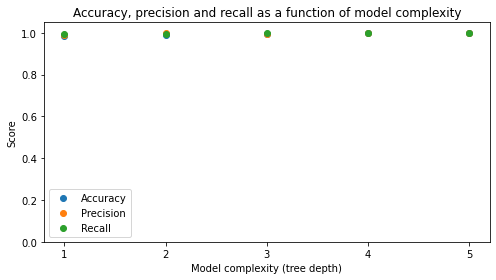

In [43]:
plot_metrics(cresci2017_cv_df, cresci2017_labels)

# Plotting performance of network stats on single plot

In [102]:
scores_dict = {
    "twibot": {
        "a": 0.8664, #accuracy
        "p": 0.8256, #precision
        "r": 0.8657, #recall
        'scores': twibot_scores
    },
    "botometer-feedback-2019": {
        'a': 0.81,
        "p": 0.84,
        "r": 0.7,
        'num_bots': 139,
        'num_humans': 380,
        'scores': botometer_feedback_scores
    },
#     "rtbust": {
#         "a": 0.8755,
#         'p': 0.9304,
#         'r': 0.9512,
#         'scores': rtbust_scores
#     },
    "midterm-2018": {
        "a": 0.987,
        'p': 0.989,
        'r': 0.995,
        'scores': midterm2018_scores
    },
    "gilani": {
        "a": 0.8644,
        'p': 0.854,
        'r': 0.822,
        'scores': gilani_processed_scores
    },
    "cresci-2017": {
        'a': 0.9871,
        'p': 0.98,
        'r': 0.98,
        'scores': cresci2017_scores
    },
    "cresci-2015": {
        "a": 0.991,
        'p': 0.994,
        'r': 0.991,
        'scores': cresci2015_scores
    },
    "caverlee-2011": {
        'a': 0.9826,
        'p': 0.89,
        'r': 0.87,
        'num_bots': 19276,
        'num_humans': 22223,
        'scores': caverlee2011_scores
    },
}
metric_names = ['accuracy', 'precision', 'recall', 'F1']

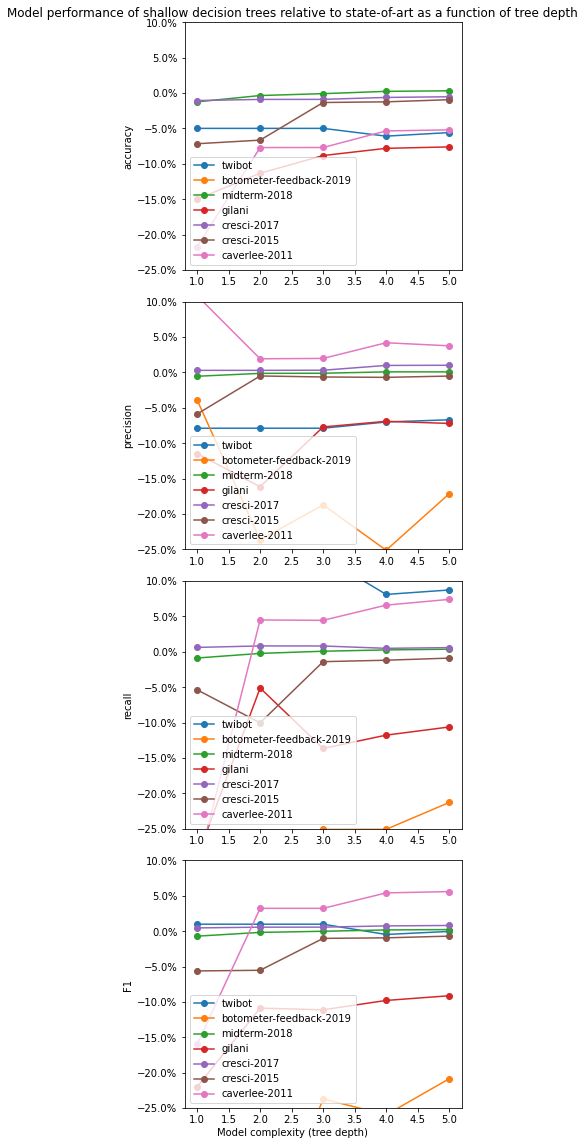

In [103]:
fig, axes = plt.subplots(4,1, figsize=(5, 16))

for i, metric_name in enumerate(metric_names):
    for name, d in scores_dict.items():
#         if (name in ['gilani', 'botometer-feedback-2019', 'rtbust']):
#             continue
        if i == 0:
            if 'a' in d:
                soa_score = d['a']
            else:
                soa_score = calculate_accuracy(d['p'], d['r'], d['num_bots'], d['num_humans'])
        if i == 1:
            soa_score = d['p']
        if i == 2:
            soa_score = d['r']
        if i == 3:
            soa_score = 2 * (d['p'] * d['r']) / (d['p'] + d['r'])

        metric_i = [(item[i] - soa_score)*100 for item in d['scores']]
        axes[i].plot(range(1,6), metric_i, label=name, marker="o")
    axes[i].set_ylabel(metric_name)
    axes[i].set_ylim((-25,10))
    yticks = mtick.PercentFormatter(is_latex=True)
    axes[i].yaxis.set_major_formatter(yticks)
    axes[i].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
fig.suptitle("Model performance of shallow decision trees relative to state-of-art as a function of tree depth")
fig.tight_layout()
plt.show()

In [43]:
for i, metric_name in enumerate(metric_names):
    for name, d in scores_dict.items():
        if i == 0:
            if 'a' in d:
                soa_score = d['a']
            else:
                continue
        if i == 1:
            soa_score = d['p']
        if i == 2:
            soa_score = d['r']
        if i == 3:
            d['f'] = 2 * (d['p'] * d['r']) / (d['p'] + d['r'])
            soa_score = d['f']
        metric_i = max([item[i] for item in d['scores']])
        delta_i = metric_i - soa_score
        d["sdt_"+metric_name] = metric_i
        d["sdt_delta_"+metric_name] = delta_i

In [44]:
score_df = pd.DataFrame(scores_dict).T

In [45]:
score_df.to_csv("bot_detection_scores.csv")

In [48]:
score_df['sdt_delta_F1']

twibot                     0.009869
botometer-feedback-2019   -0.208807
midterm-2018               0.002122
gilani                    -0.157468
cresci-2017                0.008492
cresci-2015               -0.006928
caverlee-2011              0.056293
Name: sdt_delta_F1, dtype: object